#Clustering example

### This workbook loads one experiment from the public data repository and shows the comparisson of all three clustering methods available in the library:
- MDF: Minimum average direct-flip (MDF) distance - Best for large multiexperiment dataset
- HAUS: Maximum closest distance - Best for detecting deviations from stereotypical behavior
- AMD: Average minimun distance - Best for small datasets (single experiment)


### Installs the library

In [ ]:
%%capture
!pip install cellworld

###Loads Experiment and world information

In [ ]:
from cellworld import *

#Loads the experiment:
experiment = Experiment.load_from_url("https://raw.githubusercontent.com/germanespinosa/public_data/patch-1/examples_data/example_001/experiment_data.json")

#Loads the world information
# !important: The world_implementation stored in the experiment represent the original dimensions of where the experiment was ran, experiment data is always stored in canonical.
world = World.get_from_parameters_names(experiment.world_configuration_name,
                                         "canonical", # Always use canonical to show experimental data
                                         experiment.occlusions)


###Good practice: Filter bad episodes

In [ ]:
#Detects and removes incomplete episodes (too few steps in the trajectories)
experiment.remove_episodes(experiment.get_incomplete_episodes())

#Detects and removes episodes with broken trajectories (big jumps in agent positioning, CV problems)
experiment.remove_episodes(experiment.get_broken_trajectory_episodes())

#Detects and removes episodes with wrong origin (prey did not start from the start port)
experiment.remove_episodes(experiment.get_wrong_origin_episodes())

#Detects and removes episodes with wrong goal (did not end with prey at the goal)
experiment.remove_episodes(experiment.get_wrong_goal_episodes())

### Custer the experiment trajectories

MDF clustering produces 13 clusters
HAUS clustering produces 13 clusters
AMD clustering produces 4 clusters


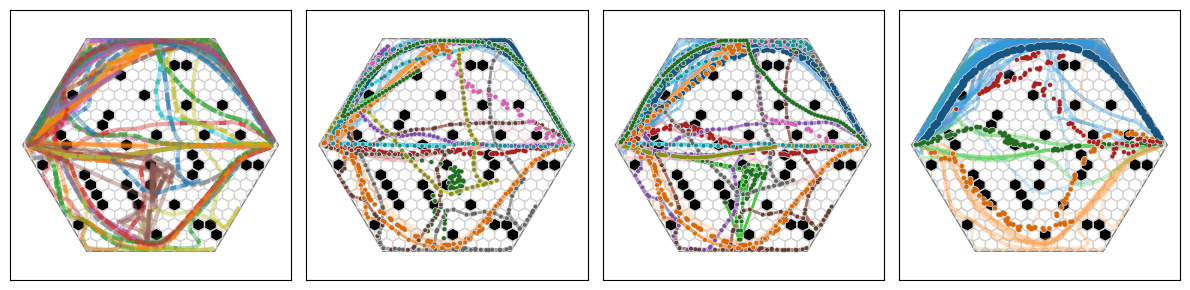

In [ ]:
import matplotlib.pyplot as plt

# MDF clustering
MDF_clustering = StreamLineClusters(distance_metric=DistanceMetric.MDF)
# HAUS clustering
HAUS_clustering = StreamLineClusters(distance_metric=DistanceMetric.HAUS)
# AMD clustering
AMD_clustering = StreamLineClusters(distance_metric=DistanceMetric.AMD)


# Creates a matplotlib figure with 4 axes, one for each map (trajectories, MDF, HAUS, and AMD)
fig, ax = plt.subplots(1, 4, figsize=(12, 3))

# Creates the display for the trajectories map on the first axis of the figure
trajectory_map = Display(world, fig_size=(3, 3), fig=fig, ax=ax[0])

# Gets a list of colors from matplotlib
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']


# Iterates through the episodes in the experiment
for episode_number, episode in enumerate(experiment.episodes):

    # Separates the prey(mouse) and the predator(robot) trajectories
    split_trajectories = episode.trajectories.split_by_agent()

    # If there is no prey trajectory it ignores the episode
    if "prey" not in split_trajectories:
        continue

    prey_trajectory = split_trajectories["prey"]

    # Clusters the prey trajectory using MDF
    MDF_clustering.add_trajectory(prey_trajectory)

    # Clusters the prey trajectory using HAUS
    HAUS_clustering.add_trajectory(prey_trajectory)

    # Clusters the prey trajectory using AMD
    AMD_clustering.add_trajectory(prey_trajectory)

    # Adds the trajectory to the trajectory map
    trajectory_map.add_trajectories(prey_trajectory,
                                    distance_equalization=True,
                                    colors={"prey": color_list[episode_number % len(color_list)]},
                                    alphas={"prey":.4})

# Creates the display for the MDF clustering result on the second axis of the figure
MDF_map = Display(world, fig_size=(3, 3), fig=fig, ax=ax[1])
# Plots the MDF clusters in the map
MDF_map.plot_clusters(MDF_clustering, colors=color_list)

# Creates the display for the HAUS clustering result on the second axis of the figure
HAUS_map = Display(world, fig_size=(3, 3), fig=fig, ax=ax[2])
# Plots the HAUS clusters in the map
HAUS_map.plot_clusters(HAUS_clustering, colors=color_list)

# Creates the display for the AMD clustering result on the second axis of the figure
AMD_map = Display(world, fig_size=(3, 3), fig=fig, ax=ax[3])
# Plots the AMD clusters in the map
AMD_map.plot_clusters(AMD_clustering, colors=color_list)

# Prints the number of clusters generated by all three algorithms
print("MDF clustering produces %i clusters" % len(MDF_clustering.clusters))
print("HAUS clustering produces %i clusters" % len(HAUS_clustering.clusters))
print("AMD clustering produces %i clusters" % len(AMD_clustering.clusters))


plt.show()